# L3: Custom Components - News Summarizer

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import warnings
from helper import load_env

warnings.filterwarnings('ignore')
load_env()

In [2]:
import requests

from typing import List

from haystack import Document, Pipeline, component
from haystack.components.builders import PromptBuilder
from haystack.components.generators.openai import OpenAIGenerator
from haystack.components.fetchers import LinkContentFetcher
from haystack.components.converters import HTMLToDocument

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

## Custom Component Requirements
#### Build a Custom Component


In [3]:
@component
class Greeter:

    @component.output_types(greeting=str)
    def run(self, user_name: str):
        return {"greeting": f"Hello {user_name}"}

#### Run the Component

In [5]:
greeter = Greeter()

greeter.run(user_name="Divanshu")

{'greeting': 'Hello Divanshu'}

#### Add the Component to a Pipeline

In [6]:
greeter = Greeter()
template = """ You will be given the beginning of a dialogue. 
Create a short play script using this as the start of the play.
Start of dialogue: {{ dialogue }}
Full script: 
"""
prompt = PromptBuilder(template=template)
llm = OpenAIGenerator()

dialogue_builder = Pipeline()
dialogue_builder.add_component("greeter", greeter)
dialogue_builder.add_component("prompt", prompt)
dialogue_builder.add_component("llm", llm)

dialogue_builder.connect("greeter.greeting", "prompt.dialogue")
dialogue_builder.connect("prompt", "llm")

🚅 Components
  - greeter: Greeter
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - greeter.greeting -> prompt.dialogue (str)
  - prompt.prompt -> llm.prompt (str)

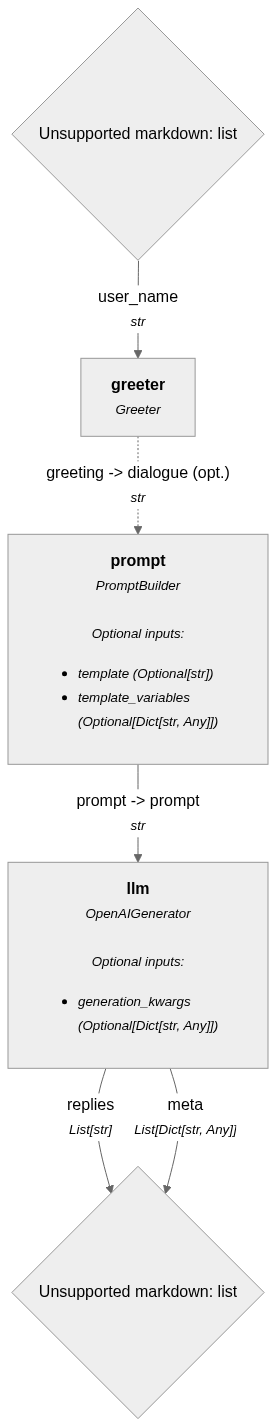

In [7]:
dialogue_builder.show()

In [21]:
dialogue = dialogue_builder.run({"greeter": {"user_name": "Divanshu"}})

print(dialogue["llm"]["replies"][0])

Title: The Reunion

Characters:
- Divanshu: A young man in his late twenties
- Shreya: Divanshu's childhood friend

[The play starts with Divanshu sitting at a cafe, sipping on his coffee. Shreya enters and approaches his table.]

Shreya: Hello Divanshu.

Divanshu: Shreya? Is that really you?

Shreya: It's me, all grown up and here to catch up with an old friend.

Divanshu: Wow, it's been so long. How have you been?

Shreya: I've been good, just living life one day at a time. And you?

Divanshu: Same here, just trying to navigate adulthood and all its challenges.

Shreya: Well, it's nice to see you again. I've missed our old conversations and adventures.

Divanshu: Me too. Remember that time we got lost in the woods and had to find our way back before sunset?

Shreya: How could I forget? We were quite the dynamic duo back then.

Divanshu: We always had each other's backs. I'm glad we could meet again after all these years.

Shreya: Me too, Divanshu. It's like no time has passed at all.

## Build a Hacker News Summarizer

> **Note:** Everyone will get different results for this application to what you see in the recording. Results depend on when you run it as it's based on 'current' top/new posts on Hacker News. 

In [9]:
trending_list = requests.get(
        url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
    )
post = requests.get(
    url=f"https://hacker-news.firebaseio.com/v0/item/{trending_list.json()[0]}.json?print=pretty"
)

print(post.json())

{'by': 'TechTechTech', 'descendants': 151, 'id': 45178041, 'kids': [45180123, 45178929, 45179299, 45179498, 45178943, 45179180, 45178860, 45179263, 45179947, 45179074, 45179062, 45179018, 45179956, 45179380, 45178978, 45179935, 45178955, 45178990, 45178988], 'score': 262, 'text': 'ASML Announcement: <a href="https:&#x2F;&#x2F;www.asml.com&#x2F;en&#x2F;news&#x2F;press-releases&#x2F;2025&#x2F;asml-mistral-ai-enter-strategic-partnership" rel="nofollow">https:&#x2F;&#x2F;www.asml.com&#x2F;en&#x2F;news&#x2F;press-releases&#x2F;2025&#x2F;asml-mistra...</a>', 'time': 1757398215, 'title': 'Mistral AI raises 1.7B€, enters strategic partnership with ASML', 'type': 'story', 'url': 'https://mistral.ai/news/mistral-ai-raises-1-7-b-to-accelerate-technological-progress-with-ai'}


In [10]:
@component
class HackernewsNewestFetcher:
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        return {"articles": articles}

In [11]:
@component
class HackernewsNewestFetcher:
    def __init__(self):
        fetcher = LinkContentFetcher()
        converter = HTMLToDocument()

        html_conversion_pipeline = Pipeline()
        html_conversion_pipeline.add_component("fetcher", fetcher)
        html_conversion_pipeline.add_component("converter", converter)

        html_conversion_pipeline.connect("fetcher", "converter")
        self.html_pipeline = html_conversion_pipeline
        
    @component.output_types(articles=List[Document])
    def run(self, top_k: int):
        articles = []
        trending_list = requests.get(
            url="https://hacker-news.firebaseio.com/v0/topstories.json?print=pretty"
        )
        for id in trending_list.json()[0:top_k]:
            post = requests.get(
                url=f"https://hacker-news.firebaseio.com/v0/item/{id}.json?print=pretty"
            )
            if "url" in post.json():
                try:
                    article = self.html_pipeline.run(
                        {"fetcher": {"urls": [post.json()["url"]]}}
                    )
                    articles.append(article["converter"]["documents"][0])
                except:
                    print(f"Can't download {post}, skipped")
            elif "text" in post.json():
                try:
                    articles.append(Document(content=post.json()["text"], meta= {"title": post.json()["title"]}))
                except:
                    print(f"Can't download {post}, skipped")
        return {"articles": articles}

In [12]:
fetcher = HackernewsNewestFetcher()
results = fetcher.run(top_k=3)

print(results['articles'])

[Document(id=38d3bb8f24b9a94815098f0ee94a7343f135d4467c86c2e881a7b6f5150a6bbf, content: 'Mistral AI raises 1.7B€ to accelerate technological progress with AI
We are announcing a Series C fu...', meta: {'content_type': 'text/html', 'url': 'https://mistral.ai/news/mistral-ai-raises-1-7-b-to-accelerate-technological-progress-with-ai'}), Document(id=be4926367f299b940f2c8a18e8667d0e921e8ede143e3f94e81ae682c91bb0e4, content: 'Types
Traits
A clickable visual guide to the Rust type system. Every type possible in Rust falls int...', meta: {'content_type': 'text/html', 'url': 'https://rustcurious.com/elements/'}), Document(id=064b0bb73e02c2d626ff82e0f03d1a95e37bcf52107fbcffe9890a79d304ccad, content: 'In the past, if you broke or lost your phone, your Signal message history was gone. This has been a ...', meta: {'content_type': 'text/html', 'url': 'https://signal.org/blog/introducing-secure-backups/'})]


In [13]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews.  
For each post, provide a brief summary if possible.
  
Posts:  
{% for article in articles %}
  Post:\n
  {{ article.content}}
{% endfor %}  
"""

In [14]:
prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

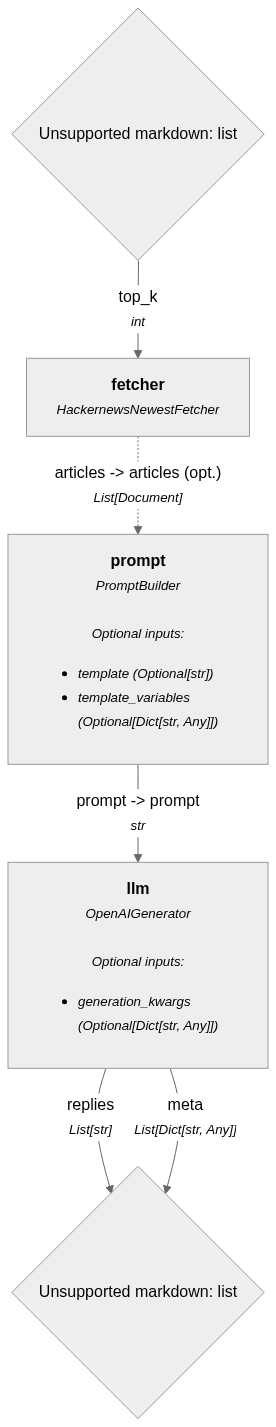

In [15]:
summarizer_pipeline.show()

In [16]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 3}})

print(summaries["llm"]["replies"][0])

1. Mistral AI raises 1.7B€ to accelerate technological progress with AI
- Mistral AI announces a Series C funding round led by ASML Holding NV, aiming to advance AI research and develop custom AI solutions to solve complex problems in various industries.

2. Types
- A visual guide to the Rust type system, focusing on lang_items and built-in types and traits in the language to support specific syntax.

3. Signal announces new secure backups feature
- Signal introduces secure backups, allowing users to save archive of their conversations in an end-to-end encrypted form, with free and paid options available. The feature is opt-in and aims to ensure privacy and security while providing a way to recover messages if a phone is lost or damaged.


In [17]:
prompt_template = """  
You will be provided a few of the top posts in HackerNews, followed by their URL.  
For each post, provide a brief summary followed by the URL the full post can be found at.  
  
Posts:  
{% for article in articles %}  
  {{ article.content }}
  URL: {{ article.meta["url"] }}
{% endfor %}  
"""

prompt_builder = PromptBuilder(template=prompt_template)
fetcher = HackernewsNewestFetcher()
llm = OpenAIGenerator()

summarizer_pipeline = Pipeline()
summarizer_pipeline.add_component("fetcher", fetcher)
summarizer_pipeline.add_component("prompt", prompt_builder)
summarizer_pipeline.add_component("llm", llm)

summarizer_pipeline.connect("fetcher.articles", "prompt.articles")
summarizer_pipeline.connect("prompt", "llm")

🚅 Components
  - fetcher: HackernewsNewestFetcher
  - prompt: PromptBuilder
  - llm: OpenAIGenerator
🛤️ Connections
  - fetcher.articles -> prompt.articles (List[Document])
  - prompt.prompt -> llm.prompt (str)

In [18]:
summaries = summarizer_pipeline.run({"fetcher": {"top_k": 2}})

print(summaries["llm"]["replies"][0])

Summary: Mistral AI has raised 1.7B€ in a Series C funding round at an 11.7B€ post-money valuation. This investment will fuel their scientific research in AI to tackle technological challenges in strategic industries. The funding round is led by ASML Holding NV and includes participation from existing investors like DST Global, Andreessen Horowitz, and NVIDIA. Mistral AI aims to continue developing AI solutions for complex engineering and industrial problems through strategic partnerships.

URL: https://mistral.ai/news/mistral-ai-raises-1-7-b-to-accelerate-technological-progress-with-ai

Summary: "Types Traits" is a visual guide to the Rust type system. It covers lang_items, types, and traits built into the language to support specific syntax, demystifying what can be built purely in library code. The focus is on Rust's platform-independent core, enabling crates in embedded firmware and systems-level contexts where no dynamic heap is available.

URL: https://rustcurious.com/elements/


### Extra resources! 

Learn more about the Haystack integrations:

* [deepset-ai github repo](https://github.com/deepset-ai/haystack-integrations)
* [haystack.deepset.ai/integrations](https://haystack.deepset.ai/integrations)